This jupyter notebook tries to predict geomagnetic storms in the next hour based on the last N hours using recurrent neural networks (RNN, more especifically GRU) for binary (storm or not) classification.
It is divided in 4 parts:
* Loading libraries and data.
* Transforming the dataset and doing some feature engineering.
* Making and fiting the model.
* Checking the results.

# Forecasting geomagnetic storms using recurrent neural networks (RNN) for classification
***


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score)

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model

from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam

In [38]:
# Load raw dataframe
df = pd.read_csv("../data/data_storms.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244535 entries, 0 to 244534
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     244535 non-null  object 
 1   ABS_B        244535 non-null  float64
 2   F            244535 non-null  float64
 3   BX_GSE       244535 non-null  float64
 4   BY_GSE       244535 non-null  float64
 5   BZ_GSE       244535 non-null  float64
 6   SIGMA-ABS_B  244535 non-null  float64
 7   SIGMA-B      244535 non-null  float64
 8   SIGMA-Bx     244535 non-null  float64
 9   SIGMA-By     244535 non-null  float64
 10  SIGMA-Bz     244535 non-null  float64
 11  T            244535 non-null  float64
 12  N            244535 non-null  float64
 13  V            244535 non-null  float64
 14  Ratio        244535 non-null  float64
 15  Pressure     244535 non-null  float64
 16  R            244535 non-null  int64  
 17  DST          244535 non-null  float64
 18  storm_now    244535 non-

# Changing the dataframe to fit RNN
***

In [39]:
# Ensure the 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244535 entries, 0 to 244534
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     244535 non-null  datetime64[ns]
 1   ABS_B        244535 non-null  float64       
 2   F            244535 non-null  float64       
 3   BX_GSE       244535 non-null  float64       
 4   BY_GSE       244535 non-null  float64       
 5   BZ_GSE       244535 non-null  float64       
 6   SIGMA-ABS_B  244535 non-null  float64       
 7   SIGMA-B      244535 non-null  float64       
 8   SIGMA-Bx     244535 non-null  float64       
 9   SIGMA-By     244535 non-null  float64       
 10  SIGMA-Bz     244535 non-null  float64       
 11  T            244535 non-null  float64       
 12  N            244535 non-null  float64       
 13  V            244535 non-null  float64       
 14  Ratio        244535 non-null  float64       
 15  Pressure     244535 non-null  floa

In [40]:
# Analyze storm distribution over time
# Number of storm-hours per year
df_storms = df.groupby(df['datetime'].dt.year)['storm_now'].agg(['sum'])
print(df_storms)

          sum
datetime     
1995      371
1996       31
1997      284
1998      555
1999      424
2000      554
2001      677
2002      904
2003      335
2004      354
2005      533
2006       93
2007       20
2008       12
2009       17
2010       84
2011      201
2012      425
2013      224
2014      163
2015      659
2016      219
2017      213
2018       80
2019       24
2020       21
2021       51
2022      159
2023      386
2024      572


In [41]:
# Number of hours with storms (count should be 8760 [24*365] or 8784 for leap years)
# values below 8784 indicate some missing hours
yearly_storms = df.groupby(df['datetime'].dt.year)['storm_now'].agg(['sum', 'count'])
print("\nHours with storm distribution by year:")
print(yearly_storms)


Hours with storm distribution by year:
          sum  count
datetime            
1995      371   8628
1996       31   8578
1997      284   8121
1998      555   8328
1999      424   6840
2000      554   7034
2001      677   7466
2002      904   7613
2003      335   6439
2004      354   6948
2005      533   8508
2006       93   7723
2007       20   8230
2008       12   8649
2009       17   8550
2010       84   7966
2011      201   8313
2012      425   8651
2013      224   8412
2014      163   6897
2015      659   8670
2016      219   8741
2017      213   8712
2018       80   8751
2019       24   8643
2020       21   8722
2021       51   8549
2022      159   8716
2023      386   8614
2024      572   8523


In [42]:
# chronological split is important for time series, so let's sort by datetime
df = df.sort_values('datetime').reset_index(drop=True)
assert df['datetime'].is_monotonic_increasing

print(df.head())

             datetime  ABS_B    F  BX_GSE  BY_GSE  BZ_GSE  SIGMA-ABS_B  \
0 1995-01-01 00:00:00    4.0  3.9    -0.6     3.2    -2.1          0.6   
1 1995-01-01 01:00:00    3.0  2.9    -0.9     2.4    -1.3          0.3   
2 1995-01-01 02:00:00    3.2  1.9     0.5     1.8    -0.4          0.7   
3 1995-01-01 03:00:00    4.3  4.0    -3.2     2.5     0.3          0.4   
4 1995-01-01 04:00:00    4.8  4.8    -4.3     2.1     0.3          0.1   

   SIGMA-B  SIGMA-Bx  SIGMA-By  SIGMA-Bz        T     N      V  Ratio  \
0      1.2       0.5       0.9       0.5  15816.0  16.3  315.0  0.016   
1      0.8       0.2       0.3       0.8  15601.0  18.8  315.0  0.013   
2      2.6       1.6       0.9       1.8  20703.0  19.3  320.0  0.012   
3      1.5       1.2       0.5       0.8  25094.0  16.4  317.0  0.013   
4      0.3       0.2       0.2       0.2  25604.0  14.5  313.0  0.015   

   Pressure   R  DST  storm_now  
0      2.87  13 -2.0          0  
1      3.28  13  3.0          0  
2      3.46  1

# Fitting the model
***

In [43]:
# let's check all columns to drop some (in the features) on the next cell
print(df.columns)

Index(['datetime', 'ABS_B', 'F', 'BX_GSE', 'BY_GSE', 'BZ_GSE', 'SIGMA-ABS_B',
       'SIGMA-B', 'SIGMA-Bx', 'SIGMA-By', 'SIGMA-Bz', 'T', 'N', 'V', 'Ratio',
       'Pressure', 'R', 'DST', 'storm_now'],
      dtype='object')


In [44]:
# Separate features and target
# I started using the DST feature, and it is very useful, but it is not always available in real-time forecasts
# datetime may not be a problem or leak information, but I am excluding it just to be sure
feature_cols = [col for col in df.columns if col not in ['datetime', 'DST', 'storm_now']] 
X = df[feature_cols].values
y = df['storm_now'].values

In [45]:
# Checking feature names
print(df[feature_cols].columns)

Index(['ABS_B', 'F', 'BX_GSE', 'BY_GSE', 'BZ_GSE', 'SIGMA-ABS_B', 'SIGMA-B',
       'SIGMA-Bx', 'SIGMA-By', 'SIGMA-Bz', 'T', 'N', 'V', 'Ratio', 'Pressure',
       'R'],
      dtype='object')


In [46]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
# This function will transform the 2D data (X) into a 3D array with the shape: 
# [number_of_samples, N_timesteps, number_of_features]
def create_sequences(X, y, time_steps):
    """
    Transforms 2D data into 3D sequences for RNN/GRU input.

    X: 2D array of features (all time steps)
    y: 1D array of targets (all time steps)
    time_steps: The lookback window (N)
    """
    Xs, ys = [], []
    # Loop starts at 'time_steps' to ensure the first sequence is complete.
    # The sequence X[i-time_steps:i] (N historical points) predicts y[i] (the next point).
    for i in range(time_steps, len(X)):
        # Input sequence: data from time t-N up to t-1
        Xs.append(X[i-time_steps:i])
        # Target: data at time t (what we are predicting)
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# lookback window of N hours
time_steps = 3 

X_sequences, y_targets = create_sequences(X_scaled, y, time_steps)

# Check the new shape
print(X_sequences.shape) # Should look like (244532, N, 17)
print(y_targets.shape)   # Should look like (244532,)

(244532, 3, 16)
(244532,)


In [48]:
# Split into train and test sets

# Use last 20% as test set and NO RANDOM SPLIT FOR TIME SERIES
split_idx = int(len(X_sequences) * 0.8)
X_train, X_test = X_sequences[:split_idx], X_sequences[split_idx:]
y_train, y_test = y_targets[:split_idx], y_targets[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")


Training samples: 195625
Test samples: 48907

Class distribution in training set:
Percentage of positive cases in train: 3.80%

Class distribution in test set:
Percentage of positive cases in test: 2.48%


In [49]:
# Get the final feature count and time steps for the model input layer
n_features = X_train.shape[2]
time_steps = X_train.shape[1]

In [50]:
# you can just load the model if already trained and not run the random search and best model again
try:
    model = load_model('./Data/storms_keras_RNN.keras')
except:
    print("No saved model found, proceeding to train a new model.")

No saved model found, proceeding to train a new model.


In [51]:
# custom metric
def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)

    # All subsequent operations will now have matching data types
    y_pred = tf.round(y_pred)

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

    beta_sq = 4.0  # 2^2
    num = (1.0 + beta_sq) * tp
    den = (1.0 + beta_sq) * tp + beta_sq * fn + fp + 1e-8

    return num / den

In [52]:
def create_model(n_features, time_steps, units_gru, units_dense, dropout_rate, learning_rate):

    """Create model with configurable hyperparameters"""
    model = Sequential([
            # 0. Input Layer
            Input(shape=(time_steps, n_features)),

            # 1. Sequential Layer (GRU)
            GRU(units=units_gru, activation='tanh', return_sequences=False),
            Dropout(dropout_rate),
            
            # 2. Classification Layer (Dense)
            Dense(units=units_dense, activation='relu'),
            Dropout(dropout_rate),
            
            # 3. Output Layer
            Dense(units=1, activation='sigmoid')
        ])
        
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss='binary_crossentropy',
        #metrics=[AUC(name='AUC'), Precision(name='Precision'), Recall(name='Recall')]
        metrics=[f2_score, 'Recall', 'AUC']
    )
    return model

In [53]:
def randomized_search(X_train, y_train, n_iter=20):
    """Random search over hyperparameters"""
    
    # Define hyperparameter ranges
    param_distributions = {
        'units_gru': [32, 64, 128, 256],
        'units_dense': [16, 32, 64],
        'dropout_rate': [0.1, 0.3, 0.5],
        'learning_rate': [1e-3, 5e-4, 1e-4],
        #'time_steps': [3, 6, 12, 24],
        'time_steps': [3],
        'batch_size': [32, 64, 128]
    }
    
    # support both 2D and 3D inputs
    if X_train.ndim == 3:
        n_samples, time_steps_from_X, n_features = X_train.shape
    else:
        n_samples, n_features = X_train.shape
        time_steps_from_X = None
    
    # Compute class weights for imbalanced dataset
    class_weights = dict(enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )))
    
    best_score = 0
    best_params = {}
    results = []
    
    print(f"Testing {n_iter} random combinations...")
    
    for i in range(n_iter):
        # Random sample from each parameter distribution
        params = {
            'units_gru': int(np.random.choice(param_distributions['units_gru'])),
            'units_dense': int(np.random.choice(param_distributions['units_dense'])),
            'dropout_rate': float(np.random.choice(param_distributions['dropout_rate'])),
            'learning_rate': float(np.random.choice(param_distributions['learning_rate'])),
            'time_steps': int(np.random.choice(param_distributions['time_steps'])),
            'batch_size': int(np.random.choice(param_distributions['batch_size']))
        }
        
        print(f"\n[{i+1}/{n_iter}] Testing: {params}")
        
        # If X_train already has time_steps dimension, ensure consistency
        if time_steps_from_X is not None and params['time_steps'] != time_steps_from_X:
            # skip incompatible combinations
            print(f"  -> Skipping params because X_train.time_steps={time_steps_from_X} != sampled time_steps={params['time_steps']}")
            continue
        
        # Create model (exclude batch_size from model creation)
        model_params = {k: v for k, v in params.items() if k != 'batch_size'}
        model = create_model(n_features=n_features, **model_params)
        
        es = EarlyStopping(patience=10, restore_best_weights=True)
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=params['batch_size'],
            callbacks=[es],
            verbose=0,
            class_weight=class_weights
        )
        
        # Get best validation (defensive access)
        #val_recall = max(history.history.get('val_recall', [0]))
        val_f2 = max(history.history.get('val_f2_score', [0]))
        print(f"  -> Val F2: {val_f2:.4f}")
        
        # Store results
        results.append({**params, 'val_f2': val_f2})
        
        # Update best
        if val_f2 > best_score:
            best_score = val_f2
            best_params = params
    
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print(f"  Best Validation F2: {best_score:.4f}")
    
    return best_params, best_score, results

In [54]:
# Search for the best hyperparameters
best_params, best_score, results = randomized_search(
    X_train, 
    y_train, 
    n_iter=50
)

Testing 50 random combinations...

[1/50] Testing: {'units_gru': 32, 'units_dense': 16, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'time_steps': 3, 'batch_size': 64}
  -> Val F2: 0.0506

[2/50] Testing: {'units_gru': 256, 'units_dense': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'time_steps': 3, 'batch_size': 128}
  -> Val F2: 0.0542

[3/50] Testing: {'units_gru': 128, 'units_dense': 32, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'time_steps': 3, 'batch_size': 64}
  -> Val F2: 0.0477

[4/50] Testing: {'units_gru': 256, 'units_dense': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'time_steps': 3, 'batch_size': 32}
  -> Val F2: 0.0438

[5/50] Testing: {'units_gru': 64, 'units_dense': 16, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'time_steps': 3, 'batch_size': 32}
  -> Val F2: 0.0454

[6/50] Testing: {'units_gru': 256, 'units_dense': 16, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'time_steps': 3, 'batch_size': 64}
  -> Val F2: 0.0480

[7/50] Testing: {'units_gru': 64,

In [55]:
# Create final model with best parameters
model = Sequential([
    Input(shape=(time_steps, n_features)),
    GRU(best_params['units_gru'], activation='tanh'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['units_dense'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])

In [56]:
# Compile with best learning rate
model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=[f2_score, 'Recall', 'AUC']
)

In [57]:
# Compute class weights for imbalanced dataset
class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)))

In [58]:
# Train the best model
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[es],
    verbose=1,
    class_weight=class_weights
)

Epoch 1/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7908 - Recall: 0.7689 - f2_score: 0.1324 - loss: 0.5689 - val_AUC: 0.9274 - val_Recall: 0.9343 - val_f2_score: 0.0673 - val_loss: 0.4631
Epoch 2/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9021 - Recall: 0.8824 - f2_score: 0.1177 - loss: 0.4085 - val_AUC: 0.9443 - val_Recall: 0.9137 - val_f2_score: 0.0591 - val_loss: 0.3223
Epoch 3/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9207 - Recall: 0.8837 - f2_score: 0.1100 - loss: 0.3638 - val_AUC: 0.9480 - val_Recall: 0.9014 - val_f2_score: 0.0563 - val_loss: 0.2794
Epoch 4/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9269 - Recall: 0.8867 - f2_score: 0.1079 - loss: 0.3483 - val_AUC: 0.9490 - val_Recall: 0.8956 - val_f2_score: 0.0551 - val_loss: 0.2650
Epoch 5/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9305 - Recall: 0.8967 - f2_score: 0.1075 - loss: 0.3403 - val_AUC: 0.9491 - val_Recall: 0.8965 - val_f2_score: 0.0552 - val_loss: 0.2617


In [59]:
# evaluate
results = model.evaluate(X_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, results)))

{'loss': 0.2624378800392151, 'compile_metrics': 0.037049733102321625}


In [60]:
# Save the best model
model.save("../data/storms_keras_RNN.keras")
print("Best model saved to ../data/storms_keras_RNN.keras")

Best model saved to ../data/storms_keras_RNN.keras


In [61]:
# Predict
y_pred_proba = model.predict(X_test).ravel()     # flatten probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)       # threshold at 0.5

1529/1529 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step


# Results
***

In [62]:
# Metrics
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if len(np.unique(y_test)) > 1:
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    f1_score = fbeta_score(y_test, y_pred, beta=1)
    recall = recall_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    metrics_table = pd.DataFrame({
        'Metric': ['F2', 'F1', 'Recall', 'Avg Precision', 'ROC AUC'],
        'Score': [f2_score, f1_score, recall, avg_precision, roc_auc]
    })
    print("\nEvaluation Metrics:")
    print(metrics_table.to_string(index=False, float_format="%.4f"))
else:
    print("Only one class present in y_test. Metrics skipped.")


Confusion Matrix:
[[40764  6930]
 [   88  1125]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     47694
           1       0.14      0.93      0.24      1213

    accuracy                           0.86     48907
   macro avg       0.57      0.89      0.58     48907
weighted avg       0.98      0.86      0.90     48907


Evaluation Metrics:
       Metric  Score
           F2 0.4358
           F1 0.2428
       Recall 0.9275
Avg Precision 0.5109
      ROC AUC 0.9594


In [63]:
# Analyze different classification thresholds
print("\nThreshold Analysis:")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


Threshold Analysis:

Threshold = 0.3
  TP: 1182, FP: 10621, TN: 37073, FN: 31
  Precision: 0.100, Recall: 0.974

Threshold = 0.4
  TP: 1158, FP: 9053, TN: 38641, FN: 55
  Precision: 0.113, Recall: 0.955

Threshold = 0.5
  TP: 1125, FP: 6930, TN: 40764, FN: 88
  Precision: 0.140, Recall: 0.927

Threshold = 0.6
  TP: 1025, FP: 4067, TN: 43627, FN: 188
  Precision: 0.201, Recall: 0.845

Threshold = 0.7
  TP: 934, FP: 2663, TN: 45031, FN: 279
  Precision: 0.260, Recall: 0.770



Visualization saved as 'geomag_storm_RNN_results.png'


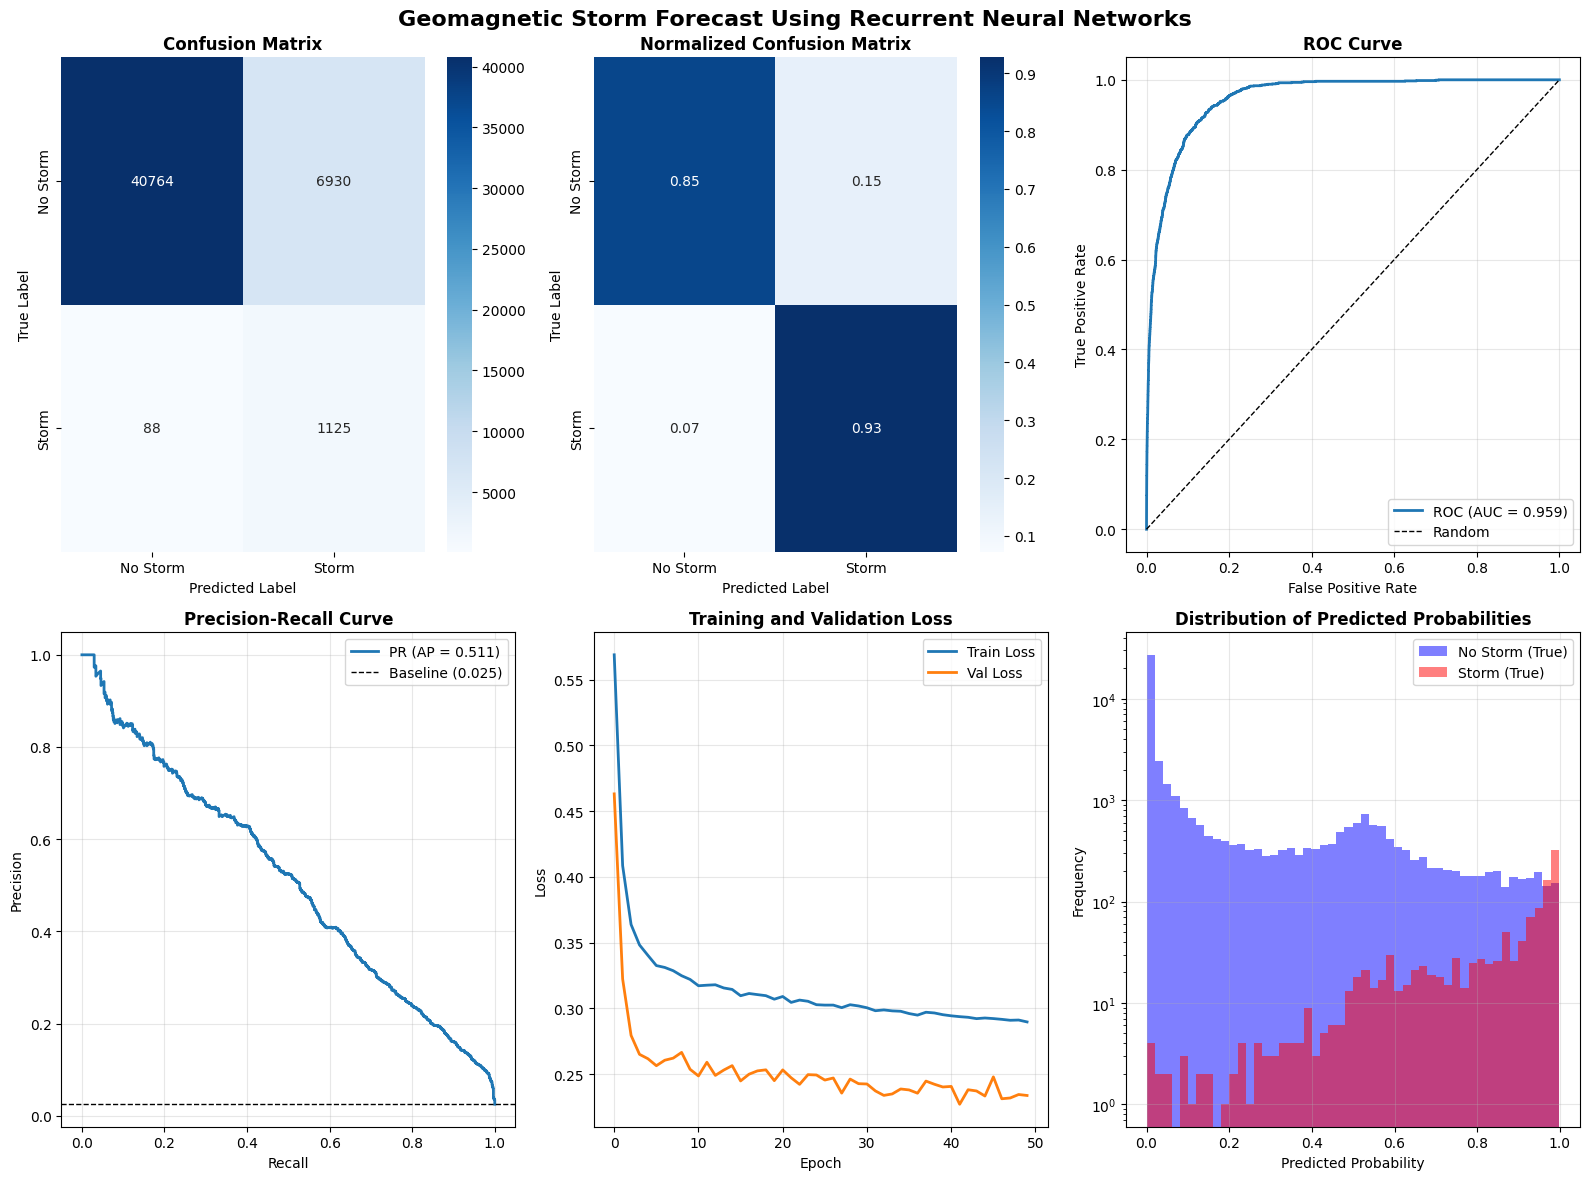

In [64]:
# Visualizations

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Geomagnetic Storm Forecast Using Recurrent Neural Networks', fontsize=16, fontweight='bold')

class_names = ['No Storm', 'Storm']

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Normalized Confusion Matrix
cm_norm = pd.DataFrame(cm).apply(lambda x: x/sum(x), axis = 1)
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', ax=ax2, xticklabels=class_names, yticklabels=class_names)
ax2.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve
if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax4 = plt.subplot(2, 3, 4)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax4.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax4.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 5. Training and Validation Loss
if 'history' in locals():
    hist = history.history
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(hist['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in hist:
        ax5.plot(hist['val_loss'], label='Val Loss', linewidth=2)
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

# 6. Prediction Probability Distribution
ax6 = plt.subplot(2, 3, 6)
ax6.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Storm (True)', color='blue')
ax6.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Storm (True)', color='red')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_yscale('log')
ax6.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/geomag_storm_RNN_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'geomag_storm_RNN_results.png'")
plt.show()